In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score
)

# Setup & Load Dataset
RSEED = 42
pd.set_option('display.max_colwidth', 120)

In [ ]:
fp = Path('bank-additional.csv')
raw = pd.read_csv(fp, sep=';')
print(raw.shape)
raw.head()

# Cek distribusi target
print(raw['y'].value_counts(normalize=True).mul(100).round(2))

(4119, 21)
y
no     89.05
yes    10.95
Name: proportion, dtype: float64


In [ ]:
X = raw.drop(columns=['y'])
y = raw['y'].map({'no': 0, 'yes': 1})

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)

In [ ]:
# Definisi pipeline terlebih dahulu
num_sel = selector(dtype_include=['int64', 'float64'])
cat_sel = selector(dtype_include=['object', 'bool'])

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

prep = ColumnTransformer([
    ('num', num_pipe, num_sel),
    ('cat', cat_pipe, cat_sel)
])

clf = DecisionTreeClassifier(random_state=RSEED)

pipe = Pipeline([
    ('prep', prep),
    ('clf', clf)
])

# Setelah pipeline didefinisikan, baru fit & evaluasi
pipe.fit(X_tr, y_tr)
yp = pipe.predict(X_te)

acc = accuracy_score(y_te, yp)
print(f'Accuracy : {acc:.4f}')
print(confusion_matrix(y_te, yp))
print(classification_report(y_te, yp, target_names=['no', 'yes']))


Accuracy : 0.8920
[[690  44]
 [ 45  45]]
              precision    recall  f1-score   support

          no       0.94      0.94      0.94       734
         yes       0.51      0.50      0.50        90

    accuracy                           0.89       824
   macro avg       0.72      0.72      0.72       824
weighted avg       0.89      0.89      0.89       824



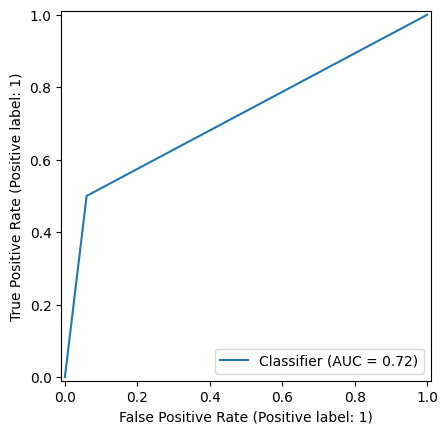

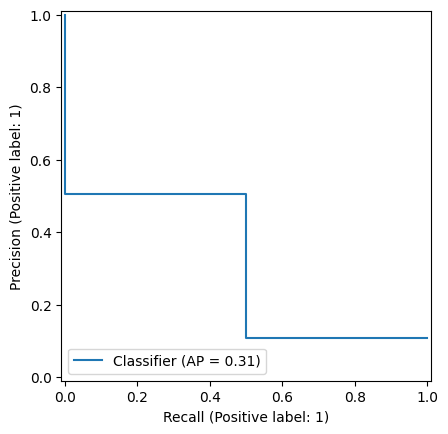

ROC-AUC : 0.72


In [ ]:
proba = pipe.predict_proba(X_te)[:, 1]
RocCurveDisplay.from_predictions(y_te, proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_te, proba)
plt.show()

print('ROC-AUC :', roc_auc_score(y_te, proba).round(4))

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 4, 6, 8, 10, 12],
    'clf__min_samples_split': [2, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 4, 8],
    'clf__max_features': [None, 'sqrt', 'log2'],
    'clf__class_weight': [None, 'balanced']
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_tr, y_tr)

print('Best params:', grid.best_params_)
print('Best CV f1 :', grid.best_score_.round(4))

best = grid.best_estimator_
print(best)


Best params: {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': None, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2}
Best CV f1 : 0.5543
Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f725462a5a0>),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(ha

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

Xt = best.named_steps['prep'].fit_transform(X_tr)

base_params = {
    k.split('__', 1)[1]: v
    for k, v in grid.best_params_.items()
    if k.startswith('clf__') and k != 'clf__class_weight'
}

clf0 = DecisionTreeClassifier(random_state=RSEED, **base_params)
clf0.fit(Xt, y_tr)

path = clf0.cost_complexity_pruning_path(Xt, y_tr)
ccp_alphas = np.unique(path.ccp_alphas)

scores = []
alphas_to_try = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 15)

for a in alphas_to_try:
    clf_a = DecisionTreeClassifier(
        random_state=RSEED,
        ccp_alpha=a,
        **base_params
    )
    pipe_a = Pipeline([
        ('prep', best.named_steps['prep']),
        ('clf', clf_a)
    ])
    s = cross_val_score(pipe_a, X_tr, y_tr, scoring='f1', cv=cv, n_jobs=-1)
    scores.append((a, float(s.mean())))

prune_df = pd.DataFrame(scores, columns=['alpha', 'f1'])
alpha_star = float(prune_df.loc[prune_df['f1'].idxmax(), 'alpha'])
print(f'Alpha terpilih: {alpha_star:.6f}')

final = Pipeline([
    ('prep', best.named_steps['prep']),
    ('clf', DecisionTreeClassifier(
        random_state=RSEED,
        ccp_alpha=alpha_star,
        **base_params
    ))
])

final.fit(X_tr, y_tr)
yp = final.predict(X_te)

print(f'Accuracy : {accuracy_score(y_te, yp):.4f}')
print(confusion_matrix(y_te, yp))
print(classification_report(y_te, yp, target_names=['no', 'yes']))


Alpha terpilih: 0.002286
Accuracy : 0.9053
[[700  34]
 [ 44  46]]
              precision    recall  f1-score   support

          no       0.94      0.95      0.95       734
         yes       0.57      0.51      0.54        90

    accuracy                           0.91       824
   macro avg       0.76      0.73      0.74       824
weighted avg       0.90      0.91      0.90       824



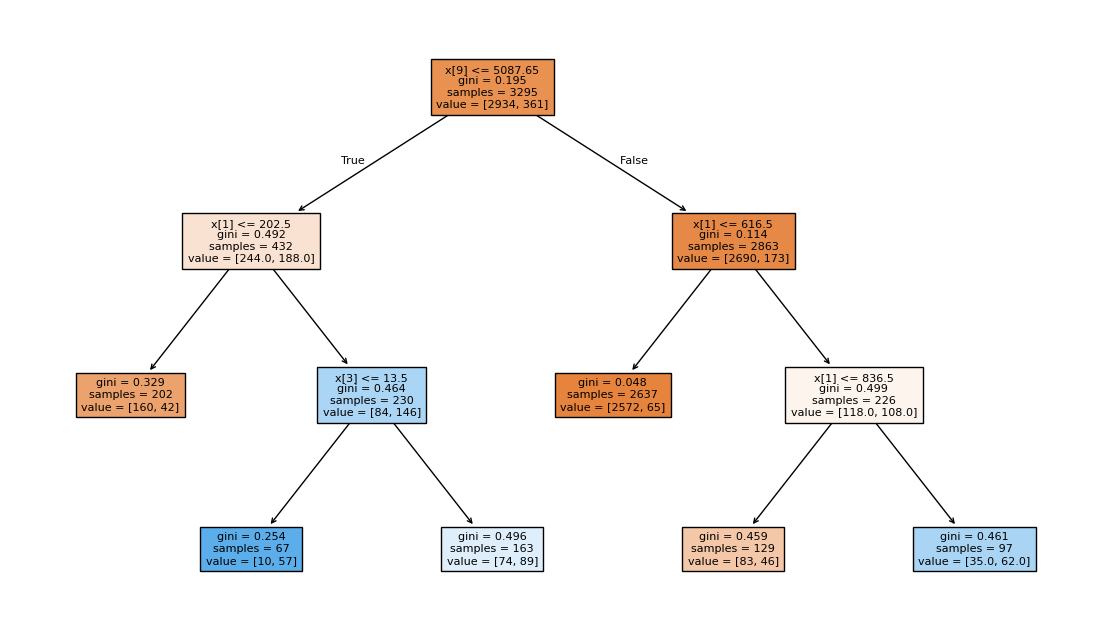

|--- nr.employed <= 5087.65
|   |--- duration <= 202.50
|   |   |--- class: 0
|   |--- duration >  202.50
|   |   |--- pdays <= 13.50
|   |   |   |--- class: 1
|   |   |--- pdays >  13.50
|   |   |   |--- class: 1
|--- nr.employed >  5087.65
|   |--- duration <= 616.50
|   |   |--- class: 0
|   |--- duration >  616.50
|   |   |--- duration <= 836.50
|   |   |   |--- class: 0
|   |   |--- duration >  836.50
|   |   |   |--- class: 1



In [ ]:
final_clf = final.named_steps['clf']
ohe = final.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
num_cols = final.named_steps['prep'].transformers_[0][2]
cat_cols = ohe.get_feature_names_out(final.named_steps['prep'].transformers_[1][2])

feat_names = np.r_[num_cols, cat_cols]

imp = pd.Series(
    final_clf.feature_importances_,
    index=feat_names
).sort_values(ascending=False)

imp.head(20)

plt.figure(figsize=(14, 8))
plot_tree(final_clf, max_depth=3, filled=True, fontsize=8)
plt.show()

print(export_text(final_clf, feature_names=list(feat_names), max_depth=3))
